In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn import Parameter
import sys
sys.path.append('../')

In [ ]:
# Use for Google drive set-up in Colab
from google.colab import drive
drive.mount('/content/gdrive')

# Set drive directory
!ls "/content/gdrive/My Drive/Colab Notebooks/Masterarbeit"
path = "/content/gdrive/My Drive/Colab Notebooks/Masterarbeit"

import os 
os.chdir(path)

# Install probtorch in Colab
!pip install git+https://github.com/probtorch/probtorch

In [2]:
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.12.1 cuda: False


# Parameters

In [ ]:
# Data parameters
SUBSET_USE = 0.1

# model parameters
NUM_PIXELS = 4096
NUM_HIDDEN = 256
NUM_DIGITS = 3
NUM_STYLE = 20   
TYPE_ARCHITECTURE = "convolutional"

# training parameters
NUM_SAMPLES = 8 # purpose: to estimate log probability ?
NUM_BATCH =  128
NUM_EPOCHS = 50
LABEL_FRACTION = 0.1
LEARNING_RATE = 1e-3
BETA1 = 0.90
BETA_ELBO = 1.0
EPS = 1e-9
CUDA = torch.cuda.is_available()
#CUDA = True

# path parameters
MODEL_NAME = 'mnist-semisupervised-%02ddim' % NUM_STYLE
DATA_PATH = '../data'
WEIGHTS_PATH = '../weights'
RESTORE = False

# Encoder Model

In [4]:
# Conv encoder, architecture adapted from Joint VAE (https://github.com/Schlumberger/joint-vae/blob/master/jointvae/models.py from line 56)
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS, 
                       num_style=NUM_STYLE,
                       num_batch=NUM_BATCH):
        super(self.__class__, self).__init__()
        self.img_to_features = nn.Sequential(
                            nn.Conv2d(1, 32, (4, 4), stride=2, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(32, 32, (4, 4), stride=2, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(32, 64, (4, 4), stride=2, padding=1),
                            nn.ReLU(),
                            nn.Conv2d(64, 64, (4, 4), stride=2, padding=1),
                            nn.ReLU())
        self.features_to_hidden = nn.Sequential(
                                    nn.Linear(64 * 4 * 4, num_hidden),
                                    nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden, num_digits)
        self.digit_temp = torch.tensor(0.66)
        self.style_mean = nn.Linear(num_hidden + num_digits, num_style)
        self.style_log_std = nn.Linear(num_hidden + num_digits, num_style)
    
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        #print("Images shape 1. encode:", images.shape)
        features = self.img_to_features(images)
        #print("Feature shapes 2. encode:", features.shape)
        hiddens = self.features_to_hidden(features.view(NUM_BATCH, -1))
        #print("Hiddens shape 3. encode:", hiddens.shape)
        if num_samples is not None: 
          hiddens = hiddens.expand((num_samples, *hiddens.shape))
        # Manual implementation of expand (@expand_inputs in utils.py)
        if labels is not None: 
          #print("Labels shape: ", labels.shape)
          labels = labels.expand((num_samples, *labels.shape))
          #print("Labels shape expanded: ", labels.shape)
        #print("Hiddens expanded shape 3. encode:", hiddens.shape)
        digits = q.concrete(logits=self.digit_log_weights(hiddens),
                            temperature=self.digit_temp,
                            value=labels,
                            name='digits')
        hiddens2 = torch.cat([digits, hiddens], -1)
        styles_mean = self.style_mean(hiddens2)
        styles_std = torch.exp(self.style_log_std(hiddens2))
        q.normal(styles_mean,
                 styles_std,
                 name='styles')
        return q

In [49]:
# Linear Encoder
class Encoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE,
                       num_batch=NUM_BATCH):
        super(self.__class__, self).__init__()
        self.enc_hidden = nn.Sequential( 
                            nn.Linear(num_pixels, num_hidden),
                            nn.ReLU(),
                            nn.Linear(num_hidden, num_hidden),
                            nn.ReLU())
        self.digit_log_weights = nn.Linear(num_hidden, num_digits)
        self.digit_temp = torch.tensor(0.66)
        self.style_mean = nn.Linear(num_hidden + num_digits, num_style)
        self.style_log_std = nn.Linear(num_hidden + num_digits, num_style)
    
    @expand_inputs
    def forward(self, images, labels=None, num_samples=None):
        q = probtorch.Trace()
        #print("Images shape 1. encode:", images.shape)
        hiddens = self.enc_hidden(images)
        #print("Hidden shapes 2. encode:", hiddens.shape)
        #print("Digit weights shapes 3. encode:", self.digit_log_weights(hiddens))
        digits = q.concrete(logits=self.digit_log_weights(hiddens),
                            temperature=self.digit_temp,
                            value=labels,
                            name='digits')
        hiddens2 = torch.cat([digits, hiddens], -1)
        styles_mean = self.style_mean(hiddens2)
        styles_std = torch.exp(self.style_log_std(hiddens2))
        q.normal(styles_mean,
                 styles_std,
                 name='styles')
        return q

# Decoder Model

In [5]:
# Conv decoder, architecture adapted from Joint VAE (https://github.com/Schlumberger/joint-vae/blob/master/jointvae/models.py from line 108)
class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE):
        super(self.__class__, self).__init__()
        self.num_digits = num_digits
        self.reshape = (64, 4, 4)
        self.digit_log_weights = torch.zeros(num_digits)
        self.digit_temp = 0.66
        self.style_mean = torch.zeros(num_style)
        self.style_std = torch.ones(num_style)
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden),
                            nn.ReLU())
        self.latent_to_features =  nn.Sequential(
                                      nn.Linear(num_style + num_digits, num_hidden),
                                      nn.ReLU(),
                                      nn.Linear(num_hidden, 64 * 4 * 4),
                                      nn.ReLU())
        self.features_to_image = nn.Sequential(
                             nn.ConvTranspose2d(64, 64, (4, 4), stride=2, padding=1),
                             nn.ReLU(),
                             nn.ConvTranspose2d(64, 32, (4, 4), stride=2, padding=1),
                             nn.ReLU(),
                             nn.ConvTranspose2d(32, 32, (4, 4), stride=2, padding=1),
                             nn.ReLU(),
                             nn.ConvTranspose2d(32, 1, (4, 4), stride=2, padding=1),
                             nn.Sigmoid())

    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        digits = p.concrete(logits=self.digit_log_weights,
                            temperature=self.digit_temp,
                            value=q['digits'],
                            name='digits')
        #print("Digit shape Decoder: ", digits.shape)
        styles = p.normal(self.style_mean, 
                          self.style_std,
                          value=q['styles'],
                          name='styles')
        #print("Styles shape Decoder: ", styles.shape)
        #torch.cat([digits, styles]).shape = [8, 128, 9]
        features = self.latent_to_features(torch.cat([digits, styles], -1))
        #print("Features shape Decoder 1.: ", features.shape)
        #Features shape Decoder 1.:  torch.Size([8, 128, 1024])
        images_mean = self.features_to_image(features.view(-1, *self.reshape))
        #print("Features shape Decoder 2.: ", images_mean.shape)
        #Features shape Decoder 2.:  torch.Size([1024, 1, 64, 64])
        if num_samples is not None: 
          images_mean = images_mean.view(-1, *(NUM_BATCH, 1, 64, 64))
        #print("Images_mean rearanged shape Decoder 3.: ", images_mean.shape)
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
               images_mean, images, name='images')
        return p

In [50]:
# Linear decoder
class Decoder(nn.Module):
    def __init__(self, num_pixels=NUM_PIXELS, 
                       num_hidden=NUM_HIDDEN,
                       num_digits=NUM_DIGITS,
                       num_style=NUM_STYLE):
        super(self.__class__, self).__init__()
        self.num_digits = num_digits
        self.digit_log_weights = torch.zeros(num_digits)
        self.digit_temp = torch.tensor(0.66)
        self.style_mean = torch.zeros(num_style)
        self.style_std = torch.ones(num_style)
        self.dec_hidden = nn.Sequential(
                            nn.Linear(num_style + num_digits, num_hidden),
                            nn.ReLU())
        self.dec_image = nn.Sequential(
                           nn.Linear(num_hidden, num_hidden),
                           nn.ReLU(),
                           nn.Linear(num_hidden, num_pixels),
                           nn.Sigmoid())

    def forward(self, images, q=None, num_samples=None):
        p = probtorch.Trace()
        digits = p.concrete(logits=self.digit_log_weights,
                            temperature=self.digit_temp,
                            value=q['digits'],
                            name='digits')
        #print("Digit shape Decoder: ", digits.shape)
        styles = p.normal(self.style_mean, 
                          self.style_std,
                          value=q['styles'],
                          name='styles')
        hiddens = self.dec_hidden(torch.cat([digits, styles], -1))
        #print("Hiddens shape Decoder 1.: ", hiddens.shape)
        images_mean = self.dec_image(hiddens)
        p.loss(lambda x_hat, x: -(torch.log(x_hat + EPS) * x + 
                                  torch.log(1 - x_hat + EPS) * (1-x)).sum(-1),
               images_mean, images, name='images')
        return p

In [ ]:
# Testign torch tensors
v = torch.zeros([128, 1, 64, 64])
p = v.expand((NUM_SAMPLES, NUM_BATCH, 1 , 64, 64))
#Features shape Decoder 2.:  torch.Size([1024, 1, 64, 64])
p.shape

w = torch.zeros([1024, 1, 64, 64])
#w = w.view(-1, *(64, 4, 4))
w = w.view(-1, *(128, 1, 64, 64))
w.shape

torch.Size([8, 128, 1, 64, 64])

# Loss

In [6]:
def elbo(q, p, beta=1.0, alpha=0.1):
    if NUM_SAMPLES is None:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=None, batch_dim=0, beta=beta, alpha=alpha)
    else:
        return probtorch.objectives.montecarlo.elbo(q, p, sample_dim=0, batch_dim=1, beta=beta, alpha=alpha)

# Data

In [32]:
# Define helpers to load dsprites 

from __future__ import print_function
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


class DisentangledSpritesDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, dir, subset_use=1.0, transform=None):
        """
        Args:
            dir (string): Directory containing the dSprites dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dir = dir
        self.filename = 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
        self.filepath = f'{self.dir}/{self.filename}'
        dataset_zip = np.load(self.filepath, allow_pickle=True, encoding='bytes')

        #print('Keys in the dataset:', dataset_zip.keys())
        dataset_size = len(dataset_zip['imgs'])
        subset_size = int(np.floor(subset_use*dataset_size))
        rand_indices = np.random.permutation(np.arange(dataset_size))[:subset_size]

        self.imgs = dataset_zip['imgs'][rand_indices]
        self.latents_values = dataset_zip['latents_values'][rand_indices]
        self.latents_classes = dataset_zip['latents_classes'][rand_indices]
        self.metadata = dataset_zip['metadata'][()]

        # print('Metadata: \n', self.metadata)
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        sample = self.imgs[idx].astype(np.float32)
        label = self.latents_values[idx,1].astype(np.int64) # 1 for shape labels (1: square, 2: circle, 3:heart)
        label -= 1 # shift labels from 1, 2, 3 to 0, 1, 2 to avoid one_hot indexing issue later on
        # sample = sample.reshape(1, sample.shape[0], sample.shape[1])
        if self.transform:
            sample = self.transform(sample)
        return sample, label


def load_dsprites(dir='/home/genyrosk/datasets',
                val_split=0.9, subset_use=1.0, shuffle=True, seed=42, batch_size=64):
    # img_size = 64
    path = os.path.join(dir, 'dsprites')
    dataset = DisentangledSpritesDataset(path, subset_use = subset_use, transform=transforms.ToTensor())

    # Create data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Create data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

In [33]:
train_data, test_data = load_dsprites(dir = DATA_PATH, subset_use=SUBSET_USE, batch_size = NUM_BATCH)

In [ ]:
""" Use for MNIST
from torchvision import datasets, transforms
import os 

if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)

train_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=True, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True) 
test_data = torch.utils.data.DataLoader(
                datasets.MNIST(DATA_PATH, train=False, download=True,
                               transform=transforms.ToTensor()),
                batch_size=NUM_BATCH, shuffle=True)
"""

tensor([2, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1, 1, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1, 1, 1,
        0, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 0, 0, 2, 0, 2,
        0, 0, 0, 2, 1, 2, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2,
        2, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 2, 2,
        1, 2, 2, 2, 2, 2, 0, 1])
Feature batch shape: torch.Size([128, 1, 64, 64])
Labels batch shape: torch.Size([128])


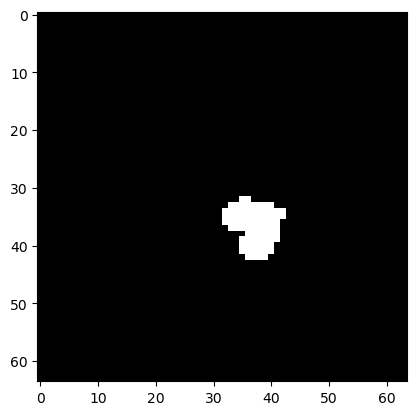

Label: 2


In [18]:
# Visualize data set and print dimensions
test_features, test_labels = next(iter(test_data))
print(test_labels)
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Training and Testing

In [34]:
def cuda_tensors(obj): 
    for attr in dir(obj):
        value = getattr(obj, attr)
        if isinstance(value, torch.Tensor):
            setattr(obj, attr, value.cuda())

enc = Encoder()
dec = Decoder()
if CUDA:
    enc.cuda()
    dec.cuda()
    cuda_tensors(enc)
    cuda_tensors(dec)

optimizer =  torch.optim.Adam(list(enc.parameters())+list(dec.parameters()),
                              lr=LEARNING_RATE,
                              betas=(BETA1, 0.999))

In [35]:
def train(data, enc, dec, optimizer, 
          label_mask={}, label_fraction=LABEL_FRACTION, beta_elbo=1.0):
    epoch_elbo = 0.0
    enc.train()
    dec.train()
    N = 0
    # b = batch index
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            if TYPE_ARCHITECTURE == "linear":
                images = images.view(-1, NUM_PIXELS)
            elif TYPE_ARCHITECTURE == "convolutional":
                pass
            else: 
                raise ValueError('Choose TYPE_ARCHITECTURE from \"linear\" or \"convolutional\".')
            #print("Image shape in train def:", images.shape)
            labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
            labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
            labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
            if CUDA:
                images = images.cuda()
                labels_onehot = labels_onehot.cuda()
            optimizer.zero_grad()
            if b not in label_mask: # option to hand over (manual) training mask, if not generated randomly according to LABEL_FRACTION
                label_mask[b] = (random() < label_fraction)
            # use label if label_mask is TRUE -> concrete() in enc() uses label 
            if label_mask[b]:
                q = enc(images, labels_onehot, num_samples=NUM_SAMPLES)
            # otherwise, concrete() samples 
            else:
                q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            loss = -elbo(q, p, beta=beta_elbo)
            loss.backward() # ?
            optimizer.step()
            if CUDA:
                loss = loss.cpu()
            epoch_elbo -= loss.item()
    return epoch_elbo / N, label_mask

def test(data, enc, dec, beta_elbo=1.0, infer=True):
    enc.eval()
    dec.eval()
    epoch_elbo = 0.0
    epoch_correct = 0
    N = 0
    for b, (images, labels) in enumerate(data):
        if images.size()[0] == NUM_BATCH:
            N += NUM_BATCH
            if TYPE_ARCHITECTURE == "linear":
                images = images.view(-1, NUM_PIXELS)
            elif TYPE_ARCHITECTURE == "convolutional":
                pass
            else: 
                raise ValueError('Choose TYPE_ARCHITECTURE from \"linear\" or \"convolutional\".')
            
            if CUDA:
                images = images.cuda()
            q = enc(images, num_samples=NUM_SAMPLES)
            p = dec(images, q, num_samples=NUM_SAMPLES)
            batch_elbo = elbo(q, p, beta=beta_elbo)
            if CUDA:
                batch_elbo = batch_elbo.cpu()
            epoch_elbo += batch_elbo.item()
            if infer:
                log_p = p.log_joint(0, 1)
                log_q = q.log_joint(0, 1)
                log_w = log_p - log_q
                w = torch.nn.functional.softmax(log_w, 0)
                y_samples = q['digits'].value
                y_expect = (w.unsqueeze(-1) * y_samples).sum(0)
                _ , y_pred = y_expect.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (labels == y_pred).sum().item()
            else:
                _, y_pred = q['digits'].value.max(-1)
                if CUDA:
                    y_pred = y_pred.cpu()
                epoch_correct += (labels == y_pred).sum().item() / (NUM_SAMPLES or 1.0)
    return epoch_elbo / N, epoch_correct / N

In [ ]:
# Explore train function in cell above

label_mask={}
label_fraction=LABEL_FRACTION
for b, (images, labels) in enumerate(train_data):
  print(images.shape)
  images = images.view(-1, NUM_PIXELS)
  print(images.shape)
  labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
  labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
  #print(labels_onehot.shape)
  labels_onehot = torch.clamp(labels_onehot, EPS, 1-EPS)
  if b not in label_mask:
                label_mask[b] = (random() < label_fraction)
  print(label_mask)
  if b == 15:
    #print(b)
    break


In [ ]:
""" Debugging one hot indexing issue
label_mask={}
label_fraction=LABEL_FRACTION
for b, (images, labels) in enumerate(train_data):
  images = images.view(-1, NUM_PIXELS)
  labels_onehot = torch.zeros(NUM_BATCH, NUM_DIGITS)
  #print(labels.unsqueeze(1))
  print(labels_onehot.shape)

  #print(labels_onehot[:2,])
  labels_onehot.scatter_(1, labels.unsqueeze(1), 1)
  print(labels_onehot[:30,])
  if b == 1:
    break
"""

In [37]:
import time
from random import random
if not RESTORE:
    mask = {}
    for e in range(NUM_EPOCHS):
        train_start = time.time()
        train_elbo, mask = train(train_data, enc, dec, 
                                 optimizer, mask, LABEL_FRACTION, beta_elbo=BETA_ELBO)
        train_end = time.time()
        test_start = time.time()
        test_elbo, test_accuracy = test(test_data, enc, dec, beta_elbo=BETA_ELBO, infer=True)
        test_end = time.time()
        print('[Epoch %d] Train: ELBO %.4e (%ds) Test: ELBO %.4e, Accuracy %0.3f (%ds)' % (
                e, train_elbo, train_end - train_start, 
                test_elbo, test_accuracy, test_end - test_start))

    if not os.path.isdir(WEIGHTS_PATH):
        os.mkdir(WEIGHTS_PATH)
    torch.save(enc.state_dict(),
               '%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))
    torch.save(dec.state_dict(),
               '%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__))

KeyboardInterrupt: 

In [ ]:
if RESTORE:
    enc.load_state_dict(torch.load('%s/%s-%s-%s-enc.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))
    dec.load_state_dict(torch.load('%s/%s-%s-%s-dec.rar' % (WEIGHTS_PATH, MODEL_NAME, probtorch.__version__, torch.__version__)))

In [55]:
print('[encoder] ELBO: %e, ACCURACY: %f' % test(test_data, enc, dec, infer=False))
print('[encoder+inference] ELBO: %e, ACCURACY: %f' % test(test_data, enc, dec, infer=True))

[encoder] ELBO: -7.964197e-01, ACCURACY: 0.416038
[encoder+inference] ELBO: -7.963819e-01, ACCURACY: 0.410307


# Visualize Embeddings

In [64]:
import numpy as np
ys = []
zs = []
for (x, y) in test_data:
    if len(x) == NUM_BATCH:
        images = x.view(-1, NUM_PIXELS)
        #images = x
        if CUDA:
            q = enc(images.cuda())
            z = q['styles'].value.cpu().detach().numpy()
        else:
            q = enc(images)
            z = q['styles'].value.data.detach().numpy()
        zs.append(z)
        ys.append(y.numpy())
ys = np.concatenate(ys,0)
zs = np.concatenate(zs,0)


In [46]:
# run TSNE when number of latent dims exceeds 2
if NUM_STYLE > 2:
    from sklearn.manifold import TSNE
    zs2 = TSNE().fit_transform(zs)
    zs2_mean = zs2.mean(0)
    zs2_std = zs2.std(0)
else:
    zs2 = zs

KeyboardInterrupt: ignored

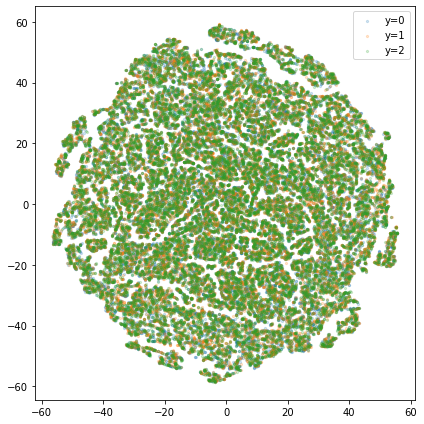

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(6,6))
ax = plt.gca()

colors = []
for k in range(NUM_DIGITS):
    m = (ys == k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%d' % k, alpha=0.2, s=5)
    colors.append(p.get_facecolor())
ax.legend()

fig.tight_layout()
#fig.savefig('images/%s-%02d-encodings.png' % (MODEL_NAME, NUM_STYLE), dpi=300)

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

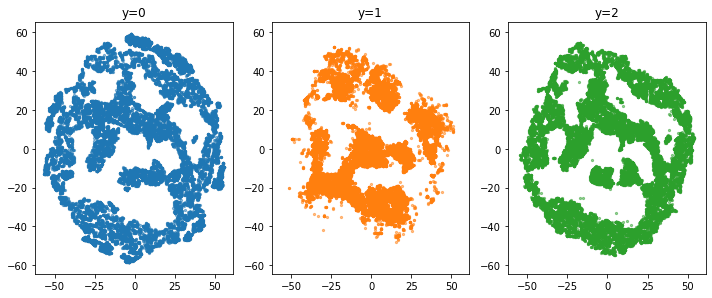

In [ ]:
# display a 2D plot of the digit classes in the latent space
fig = plt.figure(figsize=(10,4.25))

for k in range(NUM_DIGITS):
    ax = plt.subplot(1,3,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()

# Visualize Reconstructed Digits

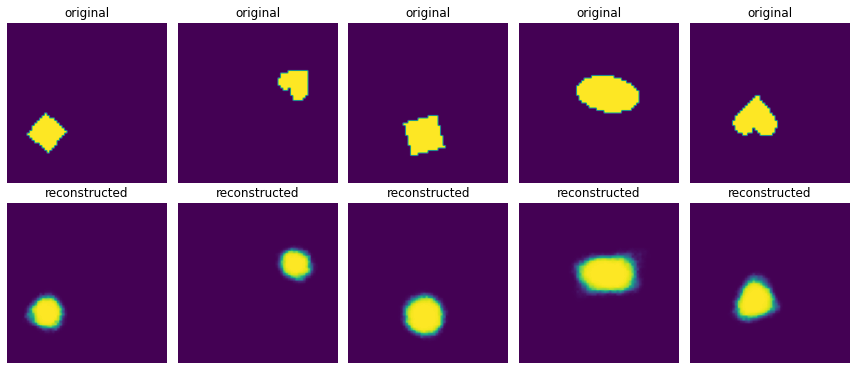

In [65]:
x,_ = next(iter(train_data))
x_var = x.view(-1, NUM_PIXELS)
#x_var = x
if CUDA:
    q = enc(x_var.cuda())
    p = dec(x_var.cuda(), q)
    x_mean = p['images'].value.view(NUM_BATCH, 64, 64).data.cpu().numpy()
else:
    q = enc(x_var)
    p = dec(x_var, q)
    x_mean = p['images'].value.view(NUM_BATCH, 64, 64).data.numpy().squeeze()
    
fig = plt.figure(figsize=(12,5.25))
for k in range(5):
    ax = plt.subplot(2, 5, k+1)
    ax.imshow(x[k].squeeze())
    ax.set_title("original")
    plt.axis("off")
    ax = plt.subplot(2, 5, k+6)
    ax.imshow(x_mean[k].squeeze())
    ax.set_title("reconstructed")
    plt.axis("off")
    
fig.tight_layout()
#fig.savefig('images/%s-%02d-reconstructions-separate.png' % (MODEL_NAME, NUM_STYLE), dpi=300, facecolor=[0,0,0,0])

RuntimeError: ignored

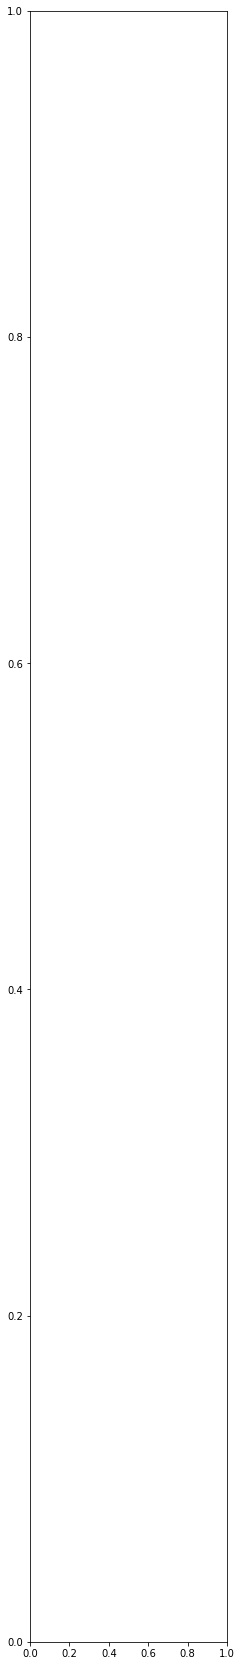

In [ ]:
# display a 2D manifold of the digits
n = 7  # figure with 15x15 digits
digit_size = 64
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
null_image = torch.tensor(np.zeros((1, 64, 64), 'f'))

plt.figure(figsize=(12, 30))
for y in range(NUM_DIGITS):
    plt.subplot(1, 3, y+1)
    y_hot = np.zeros((1,3), 'f')
    y_hot[0,y] = 1
    y_hot = torch.tensor(y_hot)
    my = (ys == y)
    for i, z0i in enumerate(grid_x):
        for j, z1j in enumerate(grid_y[-1::-1]):
            z = np.array([[z0i, z1j]], 'f')
            if NUM_STYLE > 2:
                z = zs2_mean[None,:] + zs2_std[None,:] * z
                n = ((zs2[my] - z)**2).sum(1).argmin()
                z = zs[my][n][None,:]
            z = torch.tensor(z)
            if CUDA:
                p = dec(null_image.cuda(), {'styles': z.cuda(), 'digits': y_hot.cuda()})
                images = p['images'].value.data.cpu().numpy()
            else:
                p = dec(null_image, {'styles': z, 'digits': y_hot})
                images = p['images'].value.data.numpy()
            digit = images.reshape(digit_size, digit_size)
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = digit
    plt.imshow(figure)
    plt.title('y=%d' % y)
    plt.axis('off')
plt.show()